In [1]:
import os
import numpy as np
import cv2
import pandas as pd
import k3d
import open3d as o3d
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, clear_output
import ipywidgets as widgets

In [2]:
# ---------- KITTI Utilities ---------- #

# Load LIDAR point cloud from a .bin file
def load_lidar_bin(file_path):
    # Load binary data and reshape to N x 4 (x, y, z, reflectance)
    points = np.fromfile(file_path, dtype=np.float32).reshape(-1, 4)
    # Return only x, y, z (ignore reflectance)
    return points[:, :3]

# Extract object detection labels from KITTI label file
def extract_labels(file_path):
    columns = [
        "ObjectType", "Truncation", "Occlusion", "Alpha", 
        "X1", "Y1", "X2", "Y2", "H", "W", "L", "X", "Y", "Z", "Rotation_Y"
    ]
    data = []
    with open(file_path, "r") as file:
        for line in file:
            values = line.strip().split()
            # Create a dictionary for each object, converting all values to float except ObjectType
            object_data = {
                columns[i]: values[i] if i == 0 else float(values[i])
                for i in range(len(columns))
            }
            data.append(object_data)
    # Return as a Pandas DataFrame
    return pd.DataFrame(data)

# Load calibration matrices (projection, rectification, and transformation) from file
def extract_matrices(filename):
    global P2, P3, R0_rect, Tr_velo_to_cam, Tr_cam_to_velo
    with open(filename, 'r') as file:
        for line in file:
            if line.strip():
                parts = line.split(':')
                key = parts[0].strip()
                values = np.fromstring(parts[1], sep=' ')
                # Parse and reshape the appropriate matrix
                if key == "P2":
                    P2 = values.reshape(3, 4)
                elif key == "P3":
                    P3 = values.reshape(3, 4)
                elif key == "R0_rect":
                    R0_rect = values.reshape(3, 3)
                elif key == "Tr_velo_to_cam":
                    matrix_3x4 = values.reshape(3, 4)
                    # Extend to 4x4 for homogeneous transformation
                    Tr_velo_to_cam = np.vstack([matrix_3x4, np.array([[0, 0, 0, 1]])])
                    # Inverse to get camera to lidar transformation
                    Tr_cam_to_velo = np.linalg.inv(Tr_velo_to_cam)

def compute_3D_from_disparity(right_proj_mat, disparity_img, R0_rect=None):
    """
    Compute a 3D point cloud from a disparity image using the stereo projection matrix.

    Parameters:
    - right_proj_mat: 3x4 right projection matrix 
    - disparity_img: 2D array of disparity values
    - R0_rect (optional): 3x3 rectification matrix to convert to rectified camera coordinates

    Returns:
    - xyz_img: (H, W, 3) array of 3D points in camera (or rectified) coordinates
    """

    # Convert disparity from uint16 to float if needed (KITTI format stores disparity * 256)
    if disparity_img.dtype == np.uint16:
        disparity_img = disparity_img.astype(np.float32) / 256.0

    height, width = disparity_img.shape
    xyz_img = np.full((height, width, 3), np.nan, dtype=np.float32)  # Default to NaNs

    # Extract camera intrinsics
    f = right_proj_mat[0, 0]             # Focal length (assumed fx = fy)
    c_x = right_proj_mat[0, 2]           # Principal point x
    c_y = right_proj_mat[1, 2]           # Principal point y
    T_x = right_proj_mat[0, 3]           # Translation offset (fx * baseline)

    # Compute baseline from T_x and focal length
    baseline = -T_x / f            # baseline (in meters)

    # Create a mask for valid disparity values
    mask = disparity_img > 0
    disparity = disparity_img.copy()

    # Compute depth: Z = f * B / disparity
    depth = np.full_like(disparity, np.nan, dtype=np.float32)
    depth[mask] = f * baseline / disparity[mask]

    # Generate mesh grid of pixel coordinates (u, v)
    u, v = np.meshgrid(np.arange(width), np.arange(height))

    # Compute X, Y, Z in camera coordinates
    X = (u - c_x) * depth / f
    Y = (v - c_y) * depth / f
    Z = depth

    # Stack into 3D points
    xyz_cam = np.stack((X, Y, Z), axis=-1)

    # Apply rectification if needed
    if R0_rect is not None:
        xyz_flat = xyz_cam.reshape(-1, 3)
        xyz_rect = R0_rect @ xyz_flat.T
        xyz_img = xyz_rect.reshape(height, width, 3)
    else:
        xyz_img = xyz_cam

    # # Optional: mask out distant points (e.g., beyond 17.5 meters)
    # xyz_img[xyz_img[:, :, 2] > 17.5] = np.nan
    print(xyz_img.shape)

    return xyz_img


def filter_lidar_fov(points, fov_degrees=120):
    """
    Filters 3D LIDAR points to keep only those within a given horizontal field of view (in front of the camera).
    
    Parameters:
    - points: Nx3 array of points in camera coordinates
    - fov_degrees: field of view angle in degrees (default: 120)

    Returns:
    - Filtered points within the field of view
    """
    # Compute horizontal angles (in degrees) relative to camera's forward axis
    x, y = points[:, 0], points[:, 1]
    angles = np.degrees(np.arctan2(y, x))  # Angle in degrees between -180 and 180

    # Define limits (centered around 0)
    half_fov = fov_degrees / 2.0
    mask = (angles >= -half_fov) & (angles <= half_fov)

    return points[mask]

def remove_ground_plane(points, height_threshold=-1.0, axis='z', direction='above'):
    """
    Removes ground points by filtering points below a certain height.

    Parameters:
    - points: Nx3 numpy array
    - height_threshold: height cutoff
    - axis: axis to use for height

    Returns:
    - filtered_points: points above the ground
    """
    axis_map = {'x': 0, 'y': 1, 'z': 2}
    axis_idx = axis_map.get(axis.lower(), 2)

    if direction == 'above':
        return points[points[:, axis_idx] > height_threshold]
    elif direction == 'below':
        return points[points[:, axis_idx] < height_threshold]
    else:
        raise ValueError("Direction must be 'above' or 'below'")

def clip_point_cloud(pcd, max_range=20.0):
    points = np.asarray(pcd.points)
    mask = np.linalg.norm(points, axis=1) < max_range
    pcd.points = o3d.utility.Vector3dVector(points[mask])
    return pcd

def compute_hausdorff_and_stats(pcd1, pcd2):
    """Compute symmetric Hausdorff and average distances."""
    d1 = np.asarray(pcd1.compute_point_cloud_distance(pcd2))
    d2 = np.asarray(pcd2.compute_point_cloud_distance(pcd1))

    hausdorff = max(np.max(d1), np.max(d2))
    mean1, mean2 = np.mean(d1), np.mean(d2)
    percentile_95 = np.percentile(np.concatenate([d1, d2]), 95)

    return hausdorff, mean1, mean2, percentile_95

# Transform 3D LIDAR points from LIDAR to camera coordinate system
def transform_lidar_to_camera(lidar_points, Tr_velo_to_cam):

    # Convert to homogeneous coordinates by adding 1
    ones = np.ones((lidar_points.shape[0], 1))
    lidar_hom = np.hstack((lidar_points, ones))

    # Apply transformation matrix
    cam_points = lidar_hom @ Tr_velo_to_cam.T

    return cam_points[:, :3]  # Return only x, y, z (discard homogeneous coordinate)

# Display stereo image pair side by side
def plot_img(left_path, right_path, figsize=(22, 6)):
    img_left = mpimg.imread(left_path)
    img_right = mpimg.imread(right_path)
    combined_img = np.hstack((img_left, img_right))
    plt.figure(figsize=figsize)
    plt.imshow(combined_img)
    plt.axis("off")
    plt.show()


In [3]:
# ---------- KITTI Paths ---------- #

# file_path_dataset = os.path.expanduser("~/computer_vision/Dataset")
# lidar_relative_path = "/data_object_velodyne/training/velodyne/{:06d}.bin"
# left_img_relative_path = "/data_object_image_2/training/image_2/{:06d}.png"
# right_img_relative_path = "/data_object_image_3/training/image_3/{:06d}.png"
# disparity_relative_path = "/disparity_images/disparity{:06d}.png"
# labels_relative_path = "/data_object_label_2/training/label_2/{:06d}.txt"
# calib_relative_path = "/data_object_calib/training/calib/{:06d}.txt"

file_path_dataset = os.path.expanduser("~/CV_Simina")
lidar_relative_path = "/velodyne/{:06d}.bin"
left_img_relative_path = "/image_2/{:06d}.png"
right_img_relative_path = "/image_3/{:06d}.png"
disparity_relative_path = "/disparity_images/disparity{:06d}.png"
labels_relative_path = "/data_object_label_2/{:06d}.txt"
calib_relative_path ="/data_object_calib/training/calib/{:06d}.txt"

In [4]:
sequence_number = 85
paths = {"lidar": file_path_dataset + lidar_relative_path.format(sequence_number),
        "left_img": file_path_dataset + left_img_relative_path.format(sequence_number),
        "right_img": file_path_dataset + right_img_relative_path.format(sequence_number),
        "disparity": file_path_dataset + disparity_relative_path.format(sequence_number),
        "labels": file_path_dataset + labels_relative_path.format(sequence_number),
        "calib": file_path_dataset + calib_relative_path.format(sequence_number)}

extract_matrices(paths["calib"])
lidar_points = load_lidar_bin(paths["lidar"])
lidar_points_cam = transform_lidar_to_camera(lidar_points, Tr_velo_to_cam)
lidar_points_cam = filter_lidar_fov(lidar_points_cam, fov_degrees=120)
# lidar_points_cam = remove_ground_plane(lidar_points_cam)

disparity = cv2.imread(paths["disparity"], cv2.IMREAD_UNCHANGED).astype(np.float32)
xyz_img = compute_3D_from_disparity(P3, disparity, R0_rect)

(375, 1242, 3)


In [9]:
# ---------- Visualizer Function ---------- #

def rgb_to_int(rgb_colors):
    """
    rgb_colors: np.array of size Nx3
    return: np.array of size N
    """
    # Avoid overflow issues with uint8.
    rgb_colors = rgb_colors.astype(np.uint32).T
    int_colors = (rgb_colors[0] << 16) + (rgb_colors[1] << 8) + rgb_colors[2]
    return int_colors

def bgr_to_int(bgr_colors):
    """
    bgr_colors: np.array of size Nx3
    return: np.array of size N
    """
    return rgb_to_int(bgr_colors[:, ::-1])

def visualize_frame(sequence_number):
    # Clear previous output 
    clear_output(wait=True)
    print(f"Frame: {sequence_number}")

    # Build absolute paths for the given frame
    paths = {
        "lidar": file_path_dataset + lidar_relative_path.format(sequence_number),
        "left_img": file_path_dataset + left_img_relative_path.format(sequence_number),
        "right_img": file_path_dataset + right_img_relative_path.format(sequence_number),
        "disparity": file_path_dataset + disparity_relative_path.format(sequence_number),
        "labels": file_path_dataset + labels_relative_path.format(sequence_number),
        "calib": file_path_dataset + calib_relative_path.format(sequence_number),
    }

    # Load calibration matrices and transform LIDAR points to camera coordinates
    extract_matrices(paths["calib"])
    lidar_points = load_lidar_bin(paths["lidar"])
    lidar_points_cam = filter_lidar_fov(lidar_points, fov_degrees=80)
    lidar_points_cam = remove_ground_plane(lidar_points_cam, height_threshold=-1.0, axis='z')
    lidar_points_cam = transform_lidar_to_camera(lidar_points_cam, Tr_velo_to_cam)
    
#     Tr_cam3_to_cam2 = np.array([
#     [1, 0, 0, -0.25],
#     [0, 1, 0, 0],
#     [0, 0, 1, -0.25],
#     [0, 0, 0, 1]
#     ])

#     lidar_points_cam = transform_lidar_to_camera(lidar_points_cam, Tr_cam3_to_cam2)

    # ---------- K3D Visualization ---------- #
    plot = k3d.plot(camera_auto_fit=False, axes_helper=0.0)

    # Plot LIDAR points in blue
    lidar_points_cam_rect = (R0_rect @ lidar_points_cam.T).T
    plot += k3d.points(lidar_points_cam_rect, point_size=0.05, color=0x0000ff)      # Plot rectified LiDAR Pointcloud in green
#     plot += k3d.points(lidar_points_cam, point_size=0.05, color=0x00ff00)           # Plot non-rectified Lidar Pointcloud in blue


    # Load left image and disparity
    left_img = cv2.imread(paths["left_img"], cv2.IMREAD_COLOR)
    disparity = cv2.imread(paths["disparity"], cv2.IMREAD_GRAYSCALE).astype(np.float32)

    xyz_img = compute_3D_from_disparity(P3, disparity)                             # Not rectified, add R0_rect to rectify it

    ## Downsample disparity maps --> only get the forth pixel for example
    # Subsample disparity map before computing 3D
    stride = 4  # every 4th pixel → 16x fewer points

    # Downsample disparity and image using slicing
    disparity_sub = disparity[::stride, ::stride]
    left_img_sub = left_img[::stride, ::stride]

    # Recompute point cloud on the smaller disparity map
    xyz_img_sub = compute_3D_from_disparity(P3, disparity_sub, R0_rect)

    disp_points = xyz_img.reshape(-1, 3)
    disp_points = disp_points[~np.isnan(disp_points).any(axis=1)]
    disp_points = remove_ground_plane(disp_points, height_threshold=1.0, axis='y', direction='below')
    disp_points = remove_ground_plane(disp_points, height_threshold=-1.0, axis='y', direction='above')

    # Create colors as integers for valid points
    valid_mask = ~np.isnan(xyz_img[:, :, 0])
    img_colors = left_img[valid_mask]
    img_colors = img_colors[:disp_points.shape[0]]
    color_ints = bgr_to_int(img_colors)


    # Plot using K3D
#     plot += k3d.points(positions=disp_points, colors=color_ints, point_size=0.025)
    plot += k3d.points(positions=disp_points, point_size=0.025, color=0x00ff00)

    plot.camera = [0, 0, 0, 0, 0, 15, 0, -1.0, 0]

    plot.display()


#     # Visualize stereo-derived points with color based on depth (red to green)
#     depth_vals = np.clip(disp_points[:, 2], 0, 17.5)
#     color_vals = ((depth_vals / 17.5) * 255).astype(np.uint32)
#     color_rgb = np.stack([255 - color_vals, color_vals, np.zeros_like(color_vals)], axis=1)

#     # Convert RGB to packed RGBA uint32
#     color_rgb_packed = (255 << 24) | (color_rgb[:, 0] << 16) | (color_rgb[:, 1] << 8) | color_rgb[:, 2]
#     color_rgb_packed = color_rgb_packed.astype(np.uint32)

#     # Plot with packed color array
#     plot += k3d.points(positions=disp_points.astype(np.float32), colors=color_rgb_packed, point_size=0.05)


    # # ---------- Point Cloud Alignment & Error Analysis ---------- #

    # Convert to Open3D point clouds
    pcd_disp = o3d.geometry.PointCloud()
    pcd_disp.points = o3d.utility.Vector3dVector(disp_points)
    pcd_lidar = o3d.geometry.PointCloud()
    pcd_lidar.points = o3d.utility.Vector3dVector(lidar_points_cam)

    # Remove statistical outliers to clean up noise
    pcd_disp, _ = pcd_disp.remove_statistical_outlier(20, 2.0)
    pcd_lidar, _ = pcd_lidar.remove_statistical_outlier(20, 2.0)
    
    # Remove points beyond 20 meters to remove background
    pcd_disp = clip_point_cloud(pcd_disp, max_range=10)
    pcd_lidar = clip_point_cloud(pcd_lidar, max_range=10)

    # BEFORE ICP
    hd_before, mean1_b, mean2_b, p95_b = compute_hausdorff_and_stats(pcd_disp, pcd_lidar)
    print(f"Hausdorff BEFORE ICP: {hd_before:.3f} m | Mean d1→2: {mean1_b:.3f}, d2→1: {mean2_b:.3f} | 95th%: {p95_b:.3f}")

    # Run ICP
    init_transform = np.eye(4)
#     init_transform = np.array([
#     [1, 0, 0, 1],
#     [0, 1, 0, 1],
#     [0, 0, 1, 1],
#     [0, 0, 0, 1]
#     ])
    result_icp = o3d.pipelines.registration.registration_icp(
        pcd_disp, pcd_lidar, 0.5, init_transform,
        o3d.pipelines.registration.TransformationEstimationPointToPoint()
    )

    # Print ICP results
    print(f"ICP Fitness: {result_icp.fitness:.4f}")
    print(f"ICP RMSE: {result_icp.inlier_rmse:.4f}")

    # Apply transformation
    pcd_disp.transform(result_icp.transformation)

    # AFTER ICP
    hd_after, mean1_a, mean2_a, p95_a = compute_hausdorff_and_stats(pcd_disp, pcd_lidar)
    print(f"Hausdorff AFTER ICP: {hd_after:.3f} m | Mean d1→2: {mean1_a:.3f}, d2→1: {mean2_a:.3f} | 95th%: {p95_a:.3f}")


    # Visualize aligned point clouds in Open3D viewer
    o3d.visualization.draw_geometries([pcd_disp, pcd_lidar])

    # Show stereo image pair
    plot_img(paths["left_img"], paths["right_img"])


Frame: 85
(375, 1242, 3)
(94, 311, 3)


Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper_colors=[16711680, 65280, 255], background_color=16777215, …

Output()

Hausdorff BEFORE ICP: 2.122 m | Mean d1→2: 0.620, d2→1: 0.517 | 95th%: 1.108
ICP Fitness: 0.8958
ICP RMSE: 0.2050
Hausdorff AFTER ICP: 1.738 m | Mean d1→2: 0.228, d2→1: 0.347 | 95th%: 0.631


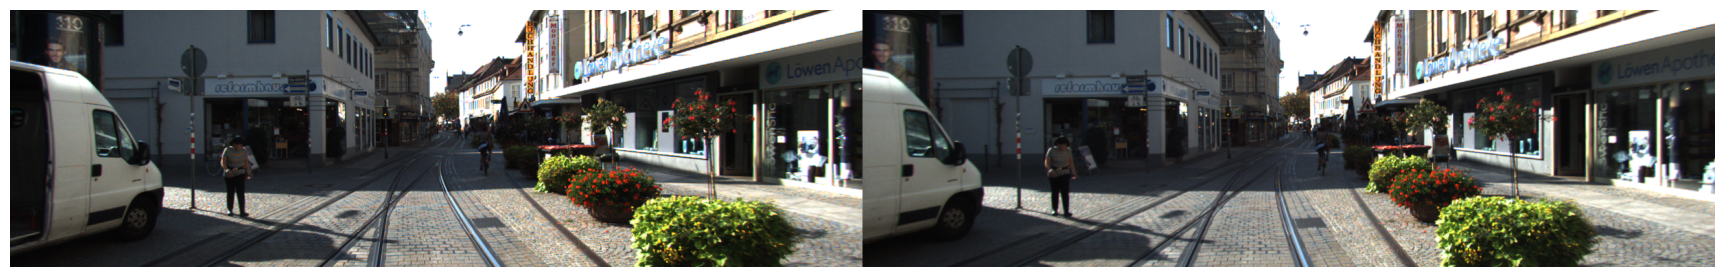

<function __main__.visualize_frame(sequence_number)>

In [10]:
# ---------- GUI Slider ---------- #

slider = widgets.IntSlider(value=85, min=85, max=85, step=1, description="Frame")
widgets.interact(visualize_frame, sequence_number=slider)


NameError: name 'disp_points' is not defined

In [13]:
# ---------- Export Functions ---------- #

def save_pointcloud_bin(filename, points):
    # Save N x 3 or N x 4 numpy array to .bin format
    if points.shape[1] == 3:
        points = np.hstack([points, np.zeros((points.shape[0], 1), dtype=np.float32)])  # add dummy intensity
    points.astype(np.float32).tofile(filename)


In [22]:

# ---------- Batch Processing ---------- #

from tqdm import tqdm

def process_all_frames(start=0, end=7481, export_dir="output/pointclouds"):
    os.makedirs(export_dir, exist_ok=True)
    hausdorff_log = []

    for sequence_number in tqdm(range(start, end), desc="Processing KITTI frames"):
        try:
            paths = {
                "lidar": file_path_dataset + lidar_relative_path.format(sequence_number),
                "disparity": file_path_dataset + disparity_relative_path.format(sequence_number),
                "calib": file_path_dataset + calib_relative_path.format(sequence_number),
            }

            extract_matrices(paths["calib"])
            lidar_points = load_lidar_bin(paths["lidar"])
            lidar_cam = transform_lidar_to_camera(lidar_points, Tr_velo_to_cam)

            disparity = cv2.imread(paths["disparity"], cv2.IMREAD_UNCHANGED).astype(np.float32)
            xyz_img = compute_3D_from_disparity(P2, disparity, R0_rect)
            disp_pc = xyz_img.reshape(-1, 3)
            disp_pc = disp_pc[~np.isnan(disp_pc).any(axis=1)]

            # Open3D ICP
            pcd_disp = o3d.geometry.PointCloud()
            pcd_disp.points = o3d.utility.Vector3dVector(disp_pc)
            pcd_lidar = o3d.geometry.PointCloud()
            pcd_lidar.points = o3d.utility.Vector3dVector(lidar_cam)
            pcd_disp, _ = pcd_disp.remove_statistical_outlier(20, 2.0)
            pcd_lidar, _ = pcd_lidar.remove_statistical_outlier(20, 2.0)

            result_icp = o3d.pipelines.registration.registration_icp(
                pcd_disp, pcd_lidar, 0.5, np.eye(4),
                o3d.pipelines.registration.TransformationEstimationPointToPoint()
            )
            pcd_disp.transform(result_icp.transformation)
            aligned_disp_pc = np.asarray(pcd_disp.points)

            # Save aligned point clouds
            save_pointcloud_bin(os.path.join(export_dir, f"{sequence_number:06d}_lidar.bin"), lidar_cam)
            save_pointcloud_bin(os.path.join(export_dir, f"{sequence_number:06d}_disp.bin"), aligned_disp_pc)

            # Log distances
            d1 = pcd_disp.compute_point_cloud_distance(pcd_lidar)
            d2 = pcd_lidar.compute_point_cloud_distance(pcd_disp)
            hausdorff = max(max(d1), max(d2))
            hausdorff_log.append((sequence_number, hausdorff))

        except Exception as e:
            print(f"Error at frame {sequence_number}: {e}")

    # Save log
    with open(os.path.join(export_dir, "hausdorff_log.csv"), "w") as f:
        f.write("frame,hausdorff")
        for frame, dist in hausdorff_log:
            f.write(f"{frame},{dist:.4f}")


In [23]:
# ---------- PointPillars Inference Placeholder ---------- #

def run_pointpillars_inference(bin_file):
    """Placeholder for PointPillars inference."""
    # Simulate loading PointPillars model
    print(f"Running PointPillars on {bin_file} ...")
    # Example: simulate result with dummy box
    dummy_boxes = [
        [10, 0, 0, 1.6, 3.9, 1.5, 0]  # [x, y, z, w, l, h, yaw]
    ]
    return dummy_boxes

def visualize_inference(bin_file):
    points = np.fromfile(bin_file, dtype=np.float32).reshape(-1, 4)[:, :3]
    bboxes = run_pointpillars_inference(bin_file)

    plot = k3d.plot()
    plot += k3d.points(points.astype(np.float32), point_size=0.05, color=0x888888)

    for bbox in bboxes:
        x, y, z, w, l, h, heading = bbox
        box = k3d.bounding_box(bounds=[x-w/2, y-l/2, z-h/2, x+w/2, y+l/2, z+h/2])
        plot += box

    plot.display()